# Aprendizaje por transferencia

El aprendizaje por transferencia (*transfer learning*) utiliza el conocimiento adquirido en una tarea para resolver una tarea relativamente similar. En el caso del aprendizaje profundo el conocimiento está representado en los pesos de una red neuronal, estos pesos se ajustan en una primera tarea y se reutilizan para resolver otra. En este caso se utiliza aprendizaje por transferencia para realizar la clasificación de imágenes de rayos x del pecho en las categorías de Neumonía o no-neumonía. 

El notebook a continuación presenta la implementación del aprendizaje utilizando la red entrenada VGG en la clasificación de las imágenes contenidas en el NIH-chest ray dataset. 

In [3]:
# Paquetes requeridos

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain

import tensorflow
#import keras
import tensorflow.keras
import sklearn
import sklearn as sk
import sklearn.model_selection as skl
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau


In [2]:
from platform import python_version
print('Python:', python_version())
#print('tensowflow:', tensorflow.__version__)
#print('keras: ', keras.__version__)

print(f"Tensor Flow Version: {tensorflow.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
#print(f"Python {system.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tensorflow.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python: 3.7.10
Tensor Flow Version: 2.1.0
Keras Version: 2.2.4-tf

Pandas 1.2.4
Scikit-Learn 0.24.2
GPU is available


In [3]:
# Experiment name
model_name = 'VGG16'

# Preprocesamiento de los Datos

## Lectura y adaptación

- El archivo separado por comas lo leemos y manipularemos con Pandas -> DataFrame
- Agregamos una columna que contenga la ruta absoluta a las imágenes
- Agregamos varias columnas extra que incluirán de forma binaria cada una de las enfermedades
- Agregamos una columna específica a la enfermedad que nos interesa

In [4]:
## Carpeta de los datos
data_folder = '../chest_x'
## Agregar columna extra al dataframe
all_xray_df = pd.read_csv(data_folder + '/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join(data_folder,'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(10)


Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
99813,00026442_000.png,No Finding,0,26442,54,F,PA,2544,3056,0.139,0.139,NaN,../chest_x\images_011\images\00026442_000.png
37074,00009771_000.png,No Finding,0,9771,26,F,PA,2048,2500,0.168,0.168,NaN,../chest_x\images_005\images\00009771_000.png
103459,00027612_000.png,No Finding,0,27612,24,M,PA,2892,2948,0.143,0.143,NaN,../chest_x\images_011\images\00027612_000.png
101378,00026928_000.png,Infiltration,0,26928,69,F,AP,3056,2544,0.139,0.139,NaN,../chest_x\images_011\images\00026928_000.png
101363,00026925_021.png,No Finding,21,26925,38,F,AP,3056,2544,0.139,0.139,NaN,../chest_x\images_011\images\00026925_021.png
83454,00020482_040.png,Infiltration,40,20482,29,F,AP,2500,2048,0.168,0.168,NaN,../chest_x\images_009\images\00020482_040.png
43485,00011226_005.png,No Finding,5,11226,53,F,AP,3056,2544,0.139,0.139,NaN,../chest_x\images_005\images\00011226_005.png
108730,00029502_001.png,Consolidation,1,29502,54,M,AP,3056,2544,0.139,0.139,NaN,../chest_x\images_012\images\00029502_001.png
90765,00022604_002.png,No Finding,2,22604,25,M,AP,3056,2544,0.139,0.139,NaN,../chest_x\images_010\images\00022604_002.png
29698,00007729_003.png,No Finding,3,7729,59,F,AP,2500,2048,0.168,0.168,NaN,../chest_x\images_004\images\00007729_003.png


In [5]:
## Agregar columnas binarias
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1:
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
53064,00013386_000.png,Atelectasis,0,13386,29,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58513,00014466_001.png,No Finding,1,14466,65,F,PA,2892,2948,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
63503,00015662_001.png,No Finding,1,15662,63,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [6]:
## Por facilidad agregaremos una columna específica a la clase que nos interesa
all_xray_df['pneumonia_class'] = all_xray_df['Finding Labels'].map(lambda finding: 'True' if 'Pneumonia' in finding else 'False')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
17614,00004748_001.png,No Finding,1,4748,10,M,PA,2048,2500,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False
87176,00021507_000.png,No Finding,0,21507,46,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False
44901,00011545_000.png,Atelectasis|Emphysema|Pneumonia,0,11545,62,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True


## División del conjunto de datos

Dividir el conjunto de datos nos permite establecer una parte que servirá como datos de entrenamiento y otro conjunto llamado validación que será utilizado para medir que tan bien está generalizando el algoritmo de aprendizaje. 

El conjunto de validación no es visto por el algoritmo de aprendizaje. 

Para darnos una idea de lo que tenemos que hacer, primero recuperaremos la distribución de las clases obtenida en el análisis exploratorio.

![](output_20_0.png)

Podemos observar que tenemos diversas clases y éstas están desbalanceadas. Como el caso de estudio es neumonía, todas las clases restantes son consideradas no-neumonía. Por lo tanto mi estrategia para contrarestar el desbalance es submuestrear la case mayoritaria e igualar el número de ejemplos de la clase minoritaria. Una vez igualadas las clases haré la división en conjunto de entrenamiento y validación.


In [7]:
# Obtener clase minoritaria
minority_class = all_xray_df[all_xray_df.Pneumonia == 1]
print('Minority class examples: ', minority_class.shape[0])
#minority_class.sample(5)

# Obtener la clase mayoritaria
majority_class = all_xray_df[all_xray_df.Pneumonia != 1]
#majority_class.sample(5)

# Remuestrear la clase mayoritaria
random_seed = 54 ## Fijar la semilla para poder replicar los experimentos en el futuro
resampled_class = sklearn.utils.resample(majority_class, replace = False, n_samples = minority_class.shape[0], random_state = random_seed, )
print('Resampled class examples: ', resampled_class.shape[0])

# Fusionar ambas clases en un nuevo DataFrame
df_balanced = pd.concat([minority_class, resampled_class])

# Dividir el conjunto de datos balanceado
train_df, valid_df = skl.train_test_split(df_balanced, test_size = 0.2, stratify = df_balanced['Pneumonia'])
n_val_examples = len(valid_df)

Minority class examples:  1431
Resampled class examples:  1431


## Aumentación de datos

- Aumentar el conjunto de entrenamiento. Aqui utilizaremos el generador de datos estándar de Keras.
- Establecer un conjunto de validación.
- Visualizar algunos ejemplos del conjunto aumentado.


In [8]:
#Hiperparámetros
batch_size = 200

# Parametros
IMG_SIZE = (224, 224)

In [9]:
# Data Generator for training includes random modifications to the images
my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

# Data generator for validation does not include random modifications
my_idg_no_augmentation = ImageDataGenerator(rescale=1. / 255.0)

train_gen = my_idg.flow_from_dataframe(  dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = batch_size
                                         )

val_gen = my_idg_no_augmentation.flow_from_dataframe(dataframe=valid_df, 
                                  directory=None, 
                                  x_col = 'path',
                                  y_col = 'pneumonia_class',
                                  class_mode = 'binary',
                                  target_size = IMG_SIZE, 
                                  batch_size = batch_size
                                  )

Found 2289 validated image filenames belonging to 2 classes.
Found 573 validated image filenames belonging to 2 classes.


In [10]:
## Pare realizar la validación del entrenamiento utilizaremos un lote de tamaño batch-size
valX, valY = val_gen.next()
print(valY)

[1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0.
 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1.
 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0.
 1. 0. 1. 1. 1. 1. 1. 1.]


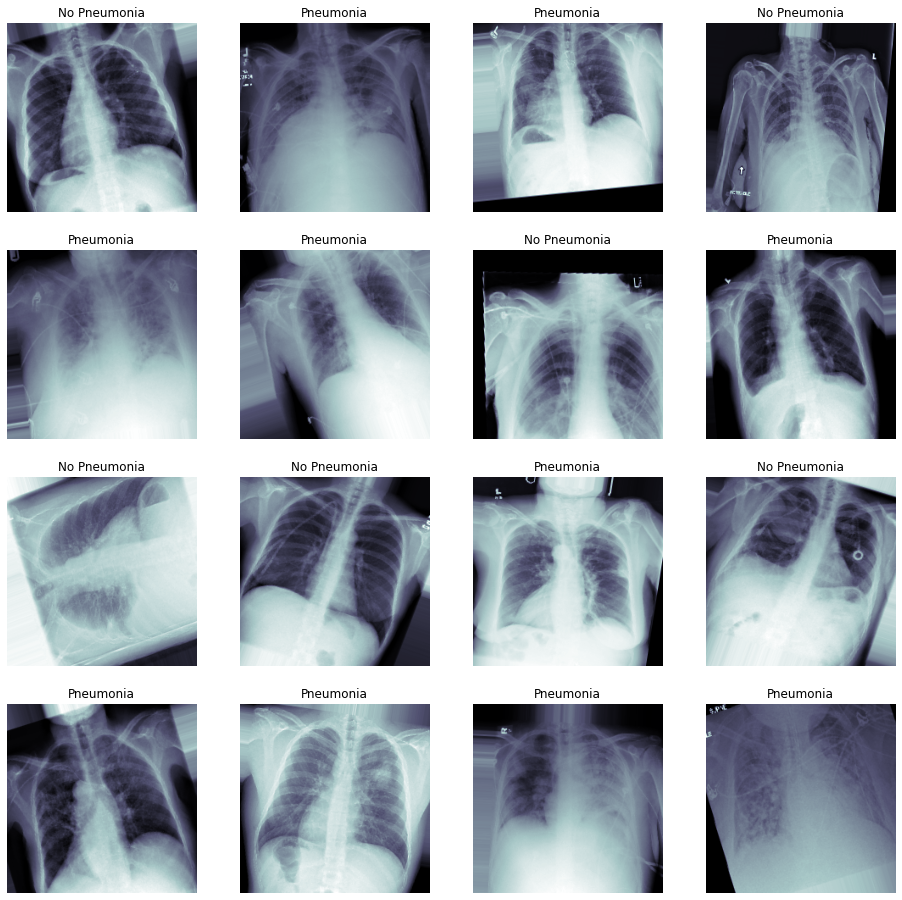

In [11]:
## Visualizar imagenes aumentadas
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

# Construcción del modelo

Utilizaremos la arquitectura de VGG16 preentrenada con el conjunto de datos de ImageNet. 

![Drag Racing](transfer.png)

En verde se muestra el modelo reutilizado, en azul los componentes congelados y en naranja los componentes a entrenar.

Los siguientes pasos son:
- Instanciar el modelo
- Descargar y asignar los pesos
- Eliminar la capa completamente conectada y mantener las capas convolucionales con sus respectivos pesos
- Agregar cuatro capas completamente conectadas con pesos aleatorios

In [12]:
modelo_original = VGG16(include_top = True, weights='imagenet')
modelo_original.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
# Obtiene la capa dado su nombre o índice
transfer_layer = modelo_original.get_layer('block5_pool')

# Agrupa las capas en un solo objeto entrenable.
# "Model groups layers into an object with training and inference features."
modelo_reutilizado = Model(inputs=modelo_original.input,
                   outputs=transfer_layer.output)

# Congelar los pesos hasta la penúltima capa convolucional
for layer in modelo_reutilizado.layers[0:17]:
    layer.trainable = False
    
for layer in modelo_reutilizado.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [14]:
modelo_personalizado = Sequential()

# Add the convolutional part of the VGG16 model from above.
modelo_personalizado.add(modelo_reutilizado)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
modelo_personalizado.add(Flatten())

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
modelo_personalizado.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
modelo_personalizado.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
modelo_personalizado.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
modelo_personalizado.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
modelo_personalizado.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
modelo_personalizado.add(Dense(256, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
modelo_personalizado.add(Dense(1, activation='sigmoid'))

## Establecer optimizador 

- Hay diversos optimizadores, Adam selecciona el valor del learning rate de forma automática conforme avanzan las épocas. 
- La métrica de pérdida es entropía cruzada binaria.
- Compilar modelo

In [15]:
## Set our optimizer, loss function, and learning rate
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [16]:
modelo_personalizado.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [17]:
## Verificar que está entrenando 
modelo_personalizado.fit_generator(train_gen, 
                                  validation_data = (valX, valY), 
                                  epochs = 1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 12 steps, validate on 200 samples
12/12 [==============================] - 44s 4s/step - loss: 0.8029 - binary_accuracy: 0.5068 - val_loss: 0.6983 - val_binary_accuracy: 0.5100


In [2]:
## Funciones callbakcs para guardar 

# archivos de mejores pesos
weight_path="{}_my_model.best.hdf5".format('xray_class')

# guardar los pesos dependiendo de la mejora
checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

# Si no mejora en 'patience' epocas terminar el entrenamiento
early = EarlyStopping( monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list = [checkpoint, early]

NameError: name 'ModelCheckpoint' is not defined

## Entrenar!

In [19]:
epochs = 100

In [20]:
history = modelo_personalizado.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = epochs, 
                           callbacks = callbacks_list)


  ...
    to  
  ['...']
Train for 12 steps, validate on 200 samples
Epoch 1/100
11/12 [==========================>...] - ETA: 3s - loss: 0.7316 - binary_accuracy: 0.5268
Epoch 00001: val_loss improved from inf to 0.68532, saving model to xray_class_my_model.best.hdf5
12/12 [==============================] - 39s 3s/step - loss: 0.7337 - binary_accuracy: 0.5256 - val_loss: 0.6853 - val_binary_accuracy: 0.5500
Epoch 2/100
11/12 [==========================>...] - ETA: 3s - loss: 0.7213 - binary_accuracy: 0.5371
Epoch 00002: val_loss improved from 0.68532 to 0.68496, saving model to xray_class_my_model.best.hdf5
12/12 [==============================] - 39s 3s/step - loss: 0.7156 - binary_accuracy: 0.5461 - val_loss: 0.6850 - val_binary_accuracy: 0.5800
Epoch 3/100
11/12 [==========================>...] - ETA: 3s - loss: 0.7145 - binary_accuracy: 0.5031
Epoch 00003: val_loss improved from 0.68496 to 0.68005, saving model to xray_class_my_model.best.hdf5
12/12 [==============================

In [21]:
# Guardar resultados
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### Graficar los resultados

- Mostar los resultados del entrenamiento

In [22]:
# Fucntion from https://github.com/datasolver/
def plot_history(history):        
    x_values = np.arange(0, len(history.history["loss"]))
    
    metrics = ["loss", "val_loss", "binary_accuracy", "val_binary_accuracy"]
    labels = ["train_loss", "val_loss", "train_acc", "val_acc"]
    markers = ['k-', 'r-', 'b-', 'g-']
    
    #plt.figure(figsize=(7,7))
    plt.plot(x_values, history.history['loss'], 'k--', label='Pérdida de ent.')
    plt.plot(x_values, history.history['val_loss'], 'r-', label='Pérdida de val.')
    plt.title("Pérdida de entrenamiento y validación")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.legend(loc="best") 
    plt.savefig(model_name + '_loss.eps', format='eps')
    plt.show()    
    
    #plt.figure(figsize=(7,7))
    plt.plot(x_values, history.history['binary_accuracy'], 'k--', label= 'Exact. de ent.')
    plt.plot(x_values, history.history['val_binary_accuracy'], 'b-', label= 'Exact. de val.')
    plt.title("Exactitud de entrenamiento y validación")
    plt.xlabel("Épocas")
    plt.ylabel("Exactitud")
    plt.legend(loc="best") 
    plt.savefig(model_name + '_acc.eps', format='eps')
    plt.show() 
    
    #for ind, metric in enumerate(metrics):
    #    plt.plot(x_values, history.history[metric], markers[ind] , label=labels[ind])
    #plt.title("Training & Validation Loss and Accuracy")
    #plt.xlabel("Epoch #")
    #plt.ylabel("Loss/Accuracy")
    #plt.legend(loc="best") 
    #plt.savefig('history.eps', format='eps')
    return

def plot_f1s(F1s):
    #plt.figure(figsize=(5,5))
    plt.plot(F1s)
    #plt.title('Puntuación F1')
    plt.title('F1 Score')
    plt.xlabel("Threshold")
    plt.ylabel("F1")
    plt.savefig(model_name + '_F1.eps', format='eps')
    plt.show()
    return


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


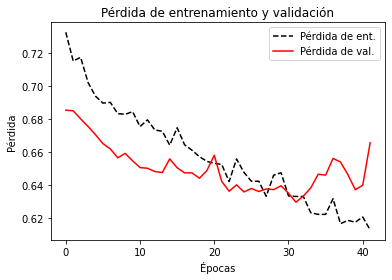

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


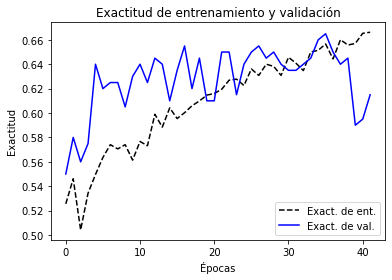

In [24]:
#np.save(history, "history.np")
plot_history(history)

## Analizar los resultados

### Realizar evaluación sobre todo el conjunto de validación

In [4]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
modelo_personalizado.load_weights(weight_path)

#pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

#for i in range(math.floor(n_val_examples/batch_size)):
#    (xval, yval)val_gen.next()
#    predy = new_model.predict(valX, batch_size = 32, verbose = True)

pred_Y = modelo_personalizado.predict(valX, batch_size = 32, verbose = True)
#pred_Y.shape

#print(pred_Y)

NameError: name 'modelo_personalizado' is not defined

### Evaluar diversas métricas

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import auc

# Graficar ROC curve
fpr, tpr, thresholds = roc_curve(valY, pred_Y, pos_label = 1)

roc_auc = auc(fpr, tpr)

display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name= model_name + '-AT')
display.plot()  
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC')
plt.savefig(model_name + '_roc.eps', format='eps')
plt.show()


In [ ]:
#y_pred_keras = keras_model.predict(X_test).ravel()

precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

auc_keras = auc(fpr, tpr)

In [ ]:
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig(model_name + '_prc.eps', format='eps')
plt.show()

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()


### Metric optimization

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
def sensibility(tp, fn):
    return tp / (tp + fn)

def specificity(tn, fp):
    return tn / (tn + fp)

def getSensAndSpec(threshold, predictions):
    over_threshold = predictions >= threshold
    over_threshold = [[1] if result[0] else [0] for result in over_threshold]
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(valY, over_threshold).ravel()
    return [sensibility(tp, fn), specificity(tn, fp)]

def getF1(threshold, predictions):
    over_threshold = predictions >= threshold
    over_threshold = [[1] if result[0] else [0] for result in over_threshold]
    return f1_score(valY, over_threshold, average='macro')

In [ ]:
# Optimization
Threshold = np.arange(0,1,0.1)

SensSpec = np.array([getSensAndSpec(thres, pred_Y) for thres in Threshold])

plt.plot(SensSpec[:,0])
plt.title('Sensibility')
plt.show()

plt.plot(SensSpec[:,1])
plt.title('Specificity')
plt.show()

In [ ]:
# Optimization
F1s = np.array([getF1(thres, pred_Y) for thres in Threshold])
plot_f1s(F1s)

### Performance of the selected threshold

In [ ]:
# Plot output distributions

plt.hist(pred_Y, bins=10)
plt.title('Distribution of CNN outputs')
plt.ylabel('Frecuency')
plt.xlabel('Logit values')
plt.savefig(model_name + '_histogram.eps', format='eps')
plt.show()


In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# I am selecting sensibility as my target metric since I want to reduce false negatives. 
# Even though the best F1 score is obtained when the threshold is equal to 0.5
# I selects threshold 0.4 because it shows a better sensibility
YOUR_THRESHOLD=0.5

over_threshold = pred_Y >= YOUR_THRESHOLD
#print(over_threshold[:10])
over_threshold = [[1] if result[0] else [0] for result in over_threshold]
#print(over_threshold[:10])

tn, fp, fn, tp = sklearn.metrics.confusion_matrix(valY, over_threshold).ravel()

print('Sensibility:', sensibility(tp, fn))
print('Specificity:', specificity(tn, fp))



In [ ]:
precision, recall, thresholds = precision_recall_curve(valY, over_threshold)
plt.plot(recall, precision)
plt.show()

In [ ]:
f1_score(valY, over_threshold, average='macro')

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    #valY
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1.: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = new_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)